In [ ]:
%matplotlib inline


# K-means clustering - PyTorch API


The :meth:`pykeops.torch.LazyTensor.argmin` reduction supported by KeOps :class:`pykeops.torch.LazyTensor` allows us
to perform **bruteforce nearest neighbor search** with four lines of code.
It can thus be used to implement a **large-scale** 
`K-means clustering <https://en.wikipedia.org/wiki/K-means_clustering>`_,
**without memory overflows**.

<div class="alert alert-info"><h4>Note</h4><p>For large and high dimensional datasets, this script 
  **outperforms its NumPy counterpart**
  as it avoids transfers between CPU (host) and GPU (device) memories.</p></div>

  


Setup 
-----------------
Standard imports:



In [ ]:
import time

import torch
from matplotlib import pyplot as plt

# from pykeops.torch import LazyTensor
import numpy as np
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}

if use_cuda:
    FloatTensor = torch.cuda.FloatTensor
    LongTensor = torch.cuda.LongTensor
else:
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor

Simple implementation of the K-means algorithm:



In [23]:
def KMeans(x, K=10, Niter=10, verbose=True):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud, 
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    c = x[:K, :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)
    start = time.time()
    for i in range(Niter):
    
        c_j = c[None, :, :]  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        D_ij_min, cl = D_ij.min(dim=1)  # Points -> Nearest cluster
        cl = cl.view(-1)
        Ncl = torch.bincount(cl).type(torchtype[dtype])  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

#         count = 0
        varience = 0
        for i in range(K):
            varience += torch.var(D_ij_min[cl == i])
#                 count += 1
#         varience /= count
    end = time.time()
    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format( 
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c, varience

# def K_means(train_data, k):
#     GVF_dim = len(train_data[0])
#     k_means = torch.rand((k, GVF_dim)).cuda()
# #     print(k_means)
#     same_num = 0
#     pbar = tqdm(total = k * GVF_dim, desc = "Clustering")
#     while True:
#         classes = torch.zeros(len(train_data)).cuda()
#         for i, n in enumerate(train_data):
#             dists = torch.cdist(n.unsqueeze(0).float().cuda(), k_means)
# #             print(dists)
#             value, idx = dists.min(1)
# #             print(dists, idx, value)
#             classes[i] = idx
#         new_k_means = torch.zeros((k, GVF_dim)).cuda()
# #         print(classes)

#         for i in range(k):
#             if train_data[classes == i].size()[0] == 0:
#                 new_k_means[i] = k_means[i]
#             else:
#                 new_k_means[i] = torch.mean(train_data[classes == i], dim = 0)
# #         print(torch.sum(k_means == new_k_means))
        
#         new_same_num = int(torch.sum(k_means == new_k_means))
# #         print(new_same_num)
#         pbar.update(new_same_num - same_num)
#         same_num = new_same_num
#         if torch.sum(k_means == new_k_means) == k * GVF_dim:
#             count = 0
#             varience = 0
#             for i in range(k):
#                 if train_data[classes == i].size()[0] != 0:
#                     varience += torch.var(train_data[classes == i])
#                     count += 1
#             varience /= count
#             break
        
#         k_means = new_k_means
        
# #         input()
#     return new_k_means, classes

K-means in 2D
----------------------
First experiment with N=10,000 points in dimension D=2, with K=50 classes:




In [24]:
N, D, K = 10000, 2, 50

Define our dataset:



In [25]:
x = torch.randn(N, D, dtype=torchtype[dtype]) / 6 + .5

Perform the computation:



In [28]:
cl, c, D_ij= KMeans(x, K)
print(cl)
print(c)
print(D_ij)
# c2, cl2 = K_means(x, K)
# print(cl2)
# print(c2)

K-means example with 10,000 points in dimension 2, K = 50:
Timing for 10 iterations: 0.05210s = 10 x 0.00521s

tensor([ 0,  1,  2,  ..., 48,  2, 31])
tensor([[0.3625, 0.6078],
        [0.2907, 0.2914],
        [0.4445, 0.4457],
        [0.4981, 0.3087],
        [0.8371, 0.3206],
        [0.5888, 0.6346],
        [0.3439, 0.1040],
        [0.5458, 0.5578],
        [0.3790, 0.5233],
        [0.6656, 0.1202],
        [0.6396, 0.5896],
        [0.5594, 0.8427],
        [0.6298, 0.7462],
        [0.8080, 0.7950],
        [0.9372, 0.3992],
        [0.2400, 0.4145],
        [0.6109, 0.2742],
        [0.4438, 0.9105],
        [0.6854, 0.6704],
        [0.4152, 0.2587],
        [0.2721, 0.5417],
        [0.4471, 0.5723],
        [0.6073, 0.3829],
        [0.5177, 0.1780],
        [0.2919, 0.8162],
        [0.8050, 0.4722],
        [0.4806, 0.5111],
        [0.5452, 0.6881],
        [0.1380, 0.7306],
        [0.1173, 0.3135],
        [0.5114, 0.7422],
        [0.5882, 0.4859],
        [0.5299, 0

Fancy display:



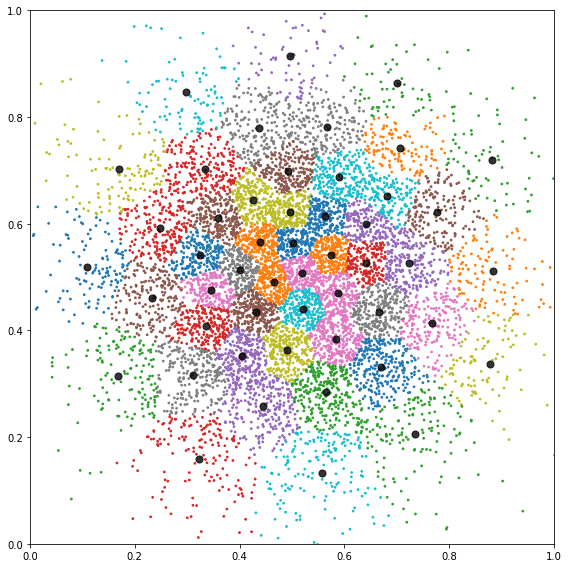

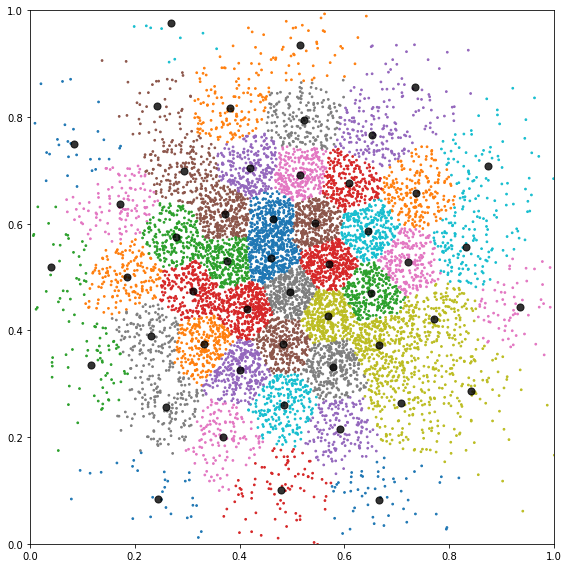

Clustering: 100%|██████████| 100/100 [00:29<00:00, 10.69it/s]

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s= 30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c='black', s=50, alpha=.8)
plt.axis([0,1,0,1]) ; plt.tight_layout() ; plt.show()

# plt.figure(figsize=(8,8))
# plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl2.cpu(), s= 30000 / len(x), cmap="tab10")
# plt.scatter(c2[:, 0].cpu(), c2[:, 1].cpu(), c='black', s=50, alpha=.8)
# plt.axis([0,1,0,1]) ; plt.tight_layout() ; plt.show()

K-means in dimension 100
-------------------------
Second experiment with N=1,000,000 points in dimension D=100, with K=1,000 classes:



In [14]:
if use_cuda:
    N, D, K = 1000000, 100, 1000
    x = torch.randn(N, D, dtype=torchtype[dtype])
    cl, c = KMeans(x, K)

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0


In [17]:
a = torch.randn(5, 4)
print(a)
print(torch.var(a, 1))

tensor([[-3.0061,  1.0469,  0.7833, -0.2153],
        [ 0.7777, -0.5548,  1.5919,  0.6468],
        [ 1.2484,  0.8659,  0.4338,  1.0987],
        [ 1.1857,  0.8310, -0.0189, -0.6131],
        [-0.2017, -0.5881, -0.2773,  0.8877]])
tensor([3.4363, 0.7834, 0.1263, 0.6644, 0.4145])
